# Rainfall seasonal cycle

Assessment of model rainfall seasonal cycle.

In [1]:
import warnings
warnings.filterwarnings('ignore')
import calendar

import numpy as np
import matplotlib.pyplot as plt
import cmocean
import cartopy.crs as ccrs

import utils

In [2]:
def monthly_climatology(da):
    """Calculate the monthly rainfall climatology"""
    
    da_monthly = da.resample(time='1M').sum('time')
    monthly_means = da_monthly.groupby('time.month').mean('time')
    monthly_means = monthly_means.compute()
    
    return monthly_means

In [3]:
def get_data(gcm, rcm, task):
    """Get rainfall data needed for the evaluation"""

    assert gcm in ['ECMWF-ERA5', 'CSIRO-ACCESS-ESM1-5']
    assert rcm in ['BOM-BARPA-R', 'CSIRO-CCAM-2203', 'UQ-DES-CCAM-2105']
    assert task in ['historical', 'xvalidation']

    if gcm == 'ECMWF-ERA5':
        start_date = '2000-01-01' if task == 'xvalidation' else '1980-01-01'
    else:
        start_date = '1990-01-01' if task == 'xvalidation' else '1980-01-01' 
    end_date = '2019-12-31'
    
    da_dict = {}
    
    da_obs = utils.get_npcp_data(
        'pr',
        'observations',
        'AGCD',
        'raw',
        'task-reference',
        start_date,
        end_date,
        'AU'
    )
    da_dict['obs'] = monthly_climatology(da_obs)
   
    da_gcm = utils.get_npcp_data(
        'pr',
        gcm,
        'GCM',
        'raw',
        'task-reference',
        start_date,
        end_date,
        'AU'
    )
    da_dict['gcm'] = monthly_climatology(da_gcm)
    
    da_rcm_raw = utils.get_npcp_data(
        'pr',
        gcm,
        rcm,
        'raw',
        'task-reference',
        start_date,
        end_date,
        'AU'
    )
    da_dict['rcm_raw'] = monthly_climatology(da_rcm_raw)
    
    da_rcm_ecdfm = utils.get_npcp_data(
        'pr',
        gcm,
        rcm,
        'ecdfm',
        f'task-{task}',
        start_date,
        end_date,
        'AU'
    )
    da_dict['rcm_ecdfm'] = monthly_climatology(da_rcm_ecdfm)
    
    da_rcm_qme = utils.get_npcp_data(
        'pr',
        gcm,
        rcm,
        'qme',
        f'task-{task}',
        start_date,
        end_date,
        'AU'
    )
    da_dict['rcm_qme'] = monthly_climatology(da_rcm_qme)
    
    if task == 'xvalidation':
        da_rcm_qdm = utils.get_npcp_data(
            'pr',
            gcm,
            rcm,
            'qdm',
            f'task-{task}',
            start_date,
            end_date,
            'AU'
        )
        da_dict['rcm_qdm'] = monthly_climatology(da_rcm_qdm)
        
    # TODO: Add additional bias correction methods as data becomes available 

    return da_dict

In [13]:
def plot_cycle_bias(ax, obs_cycle, model_cycle, cmap, levels, model_name, fraction=False):
    """Plot the cycle bias for a particular model"""
    
    monthly_bias = model_cycle - obs_cycle
    total_bias = np.abs(monthly_bias).sum(dim='month')
    if fraction:
        annual_total = obs_cycle.sum(dim='month')
        total_bias = total_bias / annual_total    
        units = 'bias (as a fraction of total annual rainfall)'
    else:
        units = 'mm'
    total_bias = utils.clip_data(total_bias, utils.get_aus_shape())

    total_bias.plot(
        ax=ax,
        transform=ccrs.PlateCarree(),
        cmap=cmap,
        levels=levels,
        extend='max',
        cbar_kwargs={'label': units},
    )
    ax.set_title(model_name)
    ax.coastlines()

In [5]:
def plot_cycle_bias_comparison(da_dict, gcm, rcm, task, cmap, levels, fraction=False):
    """Plot the complete comparison"""

    ncols = 5 if task == 'xvalidation' else 4
    
    fig = plt.figure(figsize=[7 * ncols, 5])
    ax1 = fig.add_subplot(1, ncols, 1, projection=ccrs.PlateCarree())
    plot_cycle_bias(
        ax1, da_dict['obs'], da_dict['gcm'], cmap, levels, gcm, fraction=fraction,
    )
    ax2 = fig.add_subplot(1, ncols, 2, projection=ccrs.PlateCarree())
    plot_cycle_bias(
        ax2, da_dict['obs'], da_dict['rcm_raw'], cmap, levels, f'{rcm} (raw)', fraction=fraction,
    )
    ax3 = fig.add_subplot(1, ncols, 3, projection=ccrs.PlateCarree())
    plot_cycle_bias(
        ax3, da_dict['obs'], da_dict['rcm_ecdfm'], cmap, levels, f'{rcm} (ecdfm)', fraction=fraction,
    )
    ax4 = fig.add_subplot(1, ncols, 4, projection=ccrs.PlateCarree())
    plot_cycle_bias(
        ax4, da_dict['obs'], da_dict['rcm_qme'], cmap, levels, f'{rcm} (qme)', fraction=fraction,
    )
    if task == 'xvalidation':
        ax5 = fig.add_subplot(1, ncols, 5, projection=ccrs.PlateCarree())
        plot_cycle_bias(
            ax5, da_dict['obs'], da_dict['rcm_qdm'], cmap, levels, f'{rcm} (qdm)', fraction=fraction,
        )
    long_name = da_dict['rcm_raw'].attrs['long_name']
    if gcm == 'ECMWF-ERA5':
        start_year = '2000' if task == 'xvalidation' else '1980'
    else:
        start_year = '1990' if task == 'xvalidation' else '1980'
    plt.suptitle(f'Seasonal cycle bias (model minus obs) in {start_year}-2019 monthly mean precipitation')
    plt.show()

In [6]:
cities = {
    'Hobart': {'lat': -42.9, 'lon': 147.3},
    'Melbourne': {'lat': -37.8, 'lon': 145.0},
    'Thredbo': {'lat': -36.5, 'lon': 148.3},
    'Sydney': {'lat': -33.9, 'lon': 151.2},
    'Brisbane': {'lat': -27.5, 'lon': 153.0},
    'Cairns': {'lat': -16.9, 'lon': 145.8},
    'Darwin': {'lat': -12.5, 'lon': 130.8},
    'Alice Springs': {'lat': -23.7, 'lon': 133.9},
    'Port Hedland': {'lat': -20.3, 'lon': 118.6},
    'Perth': {'lat': -32.0, 'lon': 115.9},
    'Adelaide': {'lat': -34.9, 'lon': 138.6},
}

In [7]:
def plot_city_cycle(ax, da, city, name):
    """Plot seasonal cycle"""
    
    xticks = np.arange(1, 13)
    da_point = da.sel(cities[city], method='nearest')
    ax.plot(xticks, da_point.values, label=name, linewidth=3.0, marker='o')

In [19]:
def plot_city_cycles(da_dict, gcm, rcm, task):
    """Plot the seasonal cycle for a bunch of cities"""

    xticks = np.arange(1, 13)
    xtick_labels = [calendar.month_abbr[i] for i in xticks]
    
    fig = plt.figure(figsize=[28, 15])
    for plotnum, city in enumerate(cities):
        ax = fig.add_subplot(3, 4, plotnum+1)
        plot_city_cycle(ax, da_dict['obs'], city, 'AGCD')
        plot_city_cycle(ax, da_dict['gcm'], city, gcm)
        plot_city_cycle(ax, da_dict['rcm_raw'], city, rcm)
        plot_city_cycle(ax, da_dict['rcm_ecdfm'], city, f'{rcm} (ECDFm)')
        plot_city_cycle(ax, da_dict['rcm_qme'], city, f'{rcm} (QME)')
        ax.set_title(city)
        ax.set_ylabel('monthly mean rainfall (mm)')
        ax.set_xticks(xticks, xtick_labels)
        ax.legend()
        ax.grid()
        
    if gcm == 'ECMWF-ERA5':
        start_year = '2000' if task == 'xvalidation' else '1980'
    else:
        start_year = '1990' if task == 'xvalidation' else '1980'
    plt.suptitle(f'Seasonal cycle in {start_year}-2019 monthly mean precipitation')
    plt.show()

## task-historical

Bias corrected data for the 1980-2019 period, using 1980-2019 as a training period.

In [9]:
variable = 'pr'
bias_levels = np.arange(0, 450, 50)
frac_levels = np.arange(0, 1.5, 0.15)
cmap = 'magma_r'

#### ERA5

In [11]:
gcm = 'ECMWF-ERA5'
rcm = 'BOM-BARPA-R'
task = 'historical'
da_dict = get_data(gcm, rcm, task)

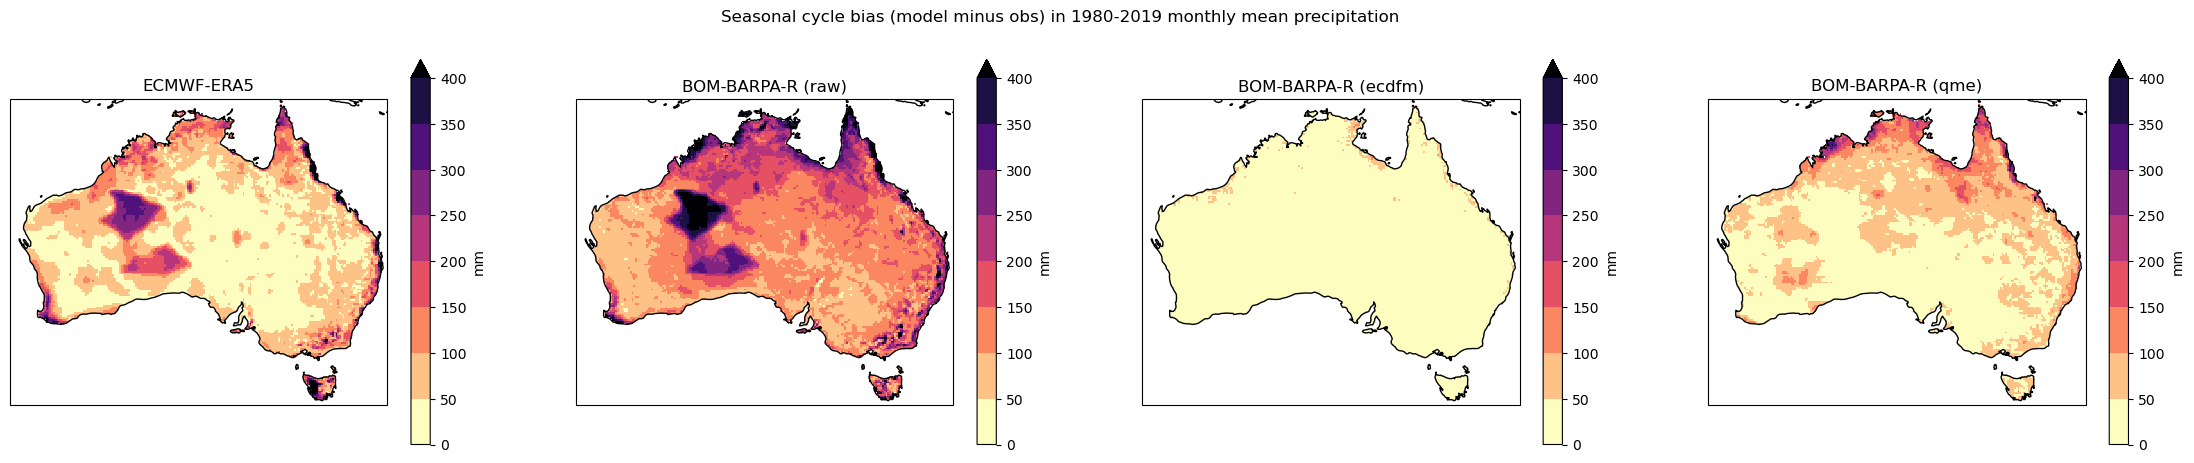

In [14]:
plot_cycle_bias_comparison(da_dict, gcm, rcm, task, cmap, bias_levels, fraction=False)

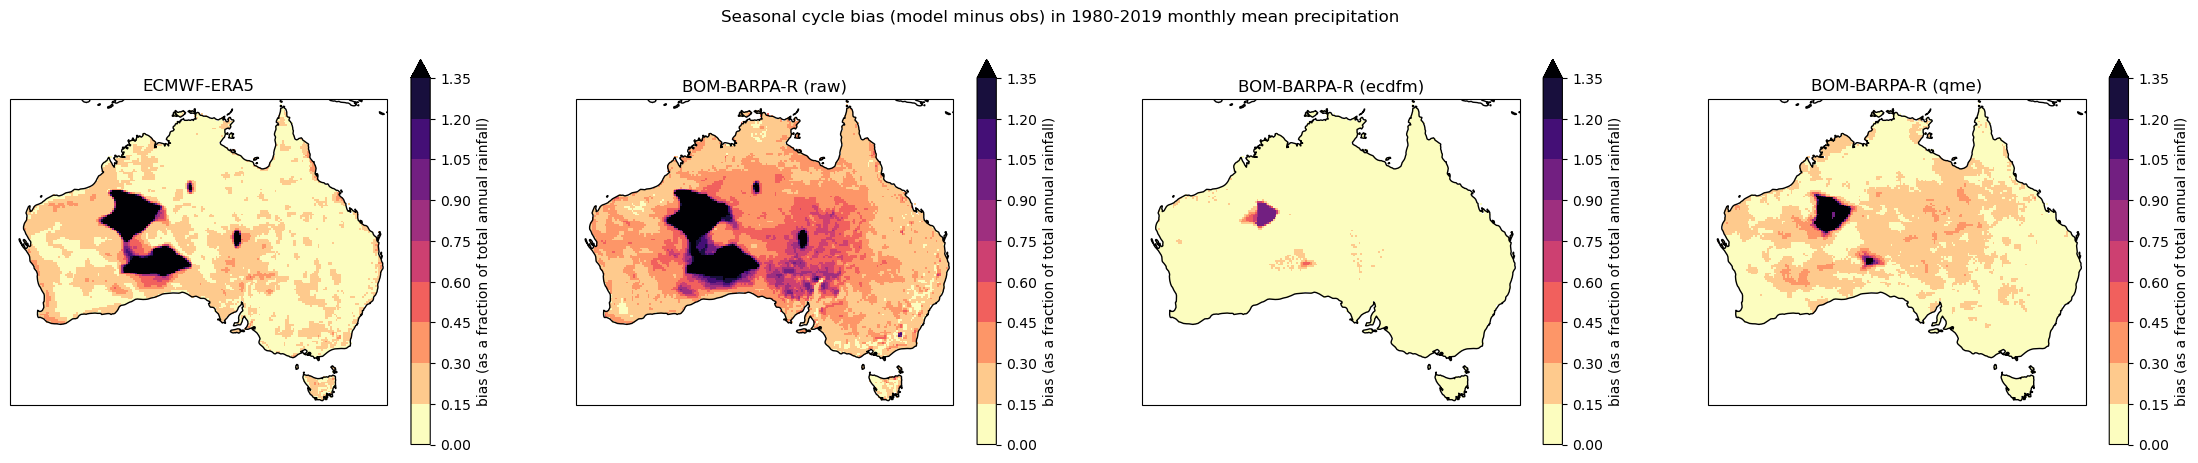

In [15]:
plot_cycle_bias_comparison(da_dict, gcm, rcm, task, cmap, frac_levels, fraction=True)

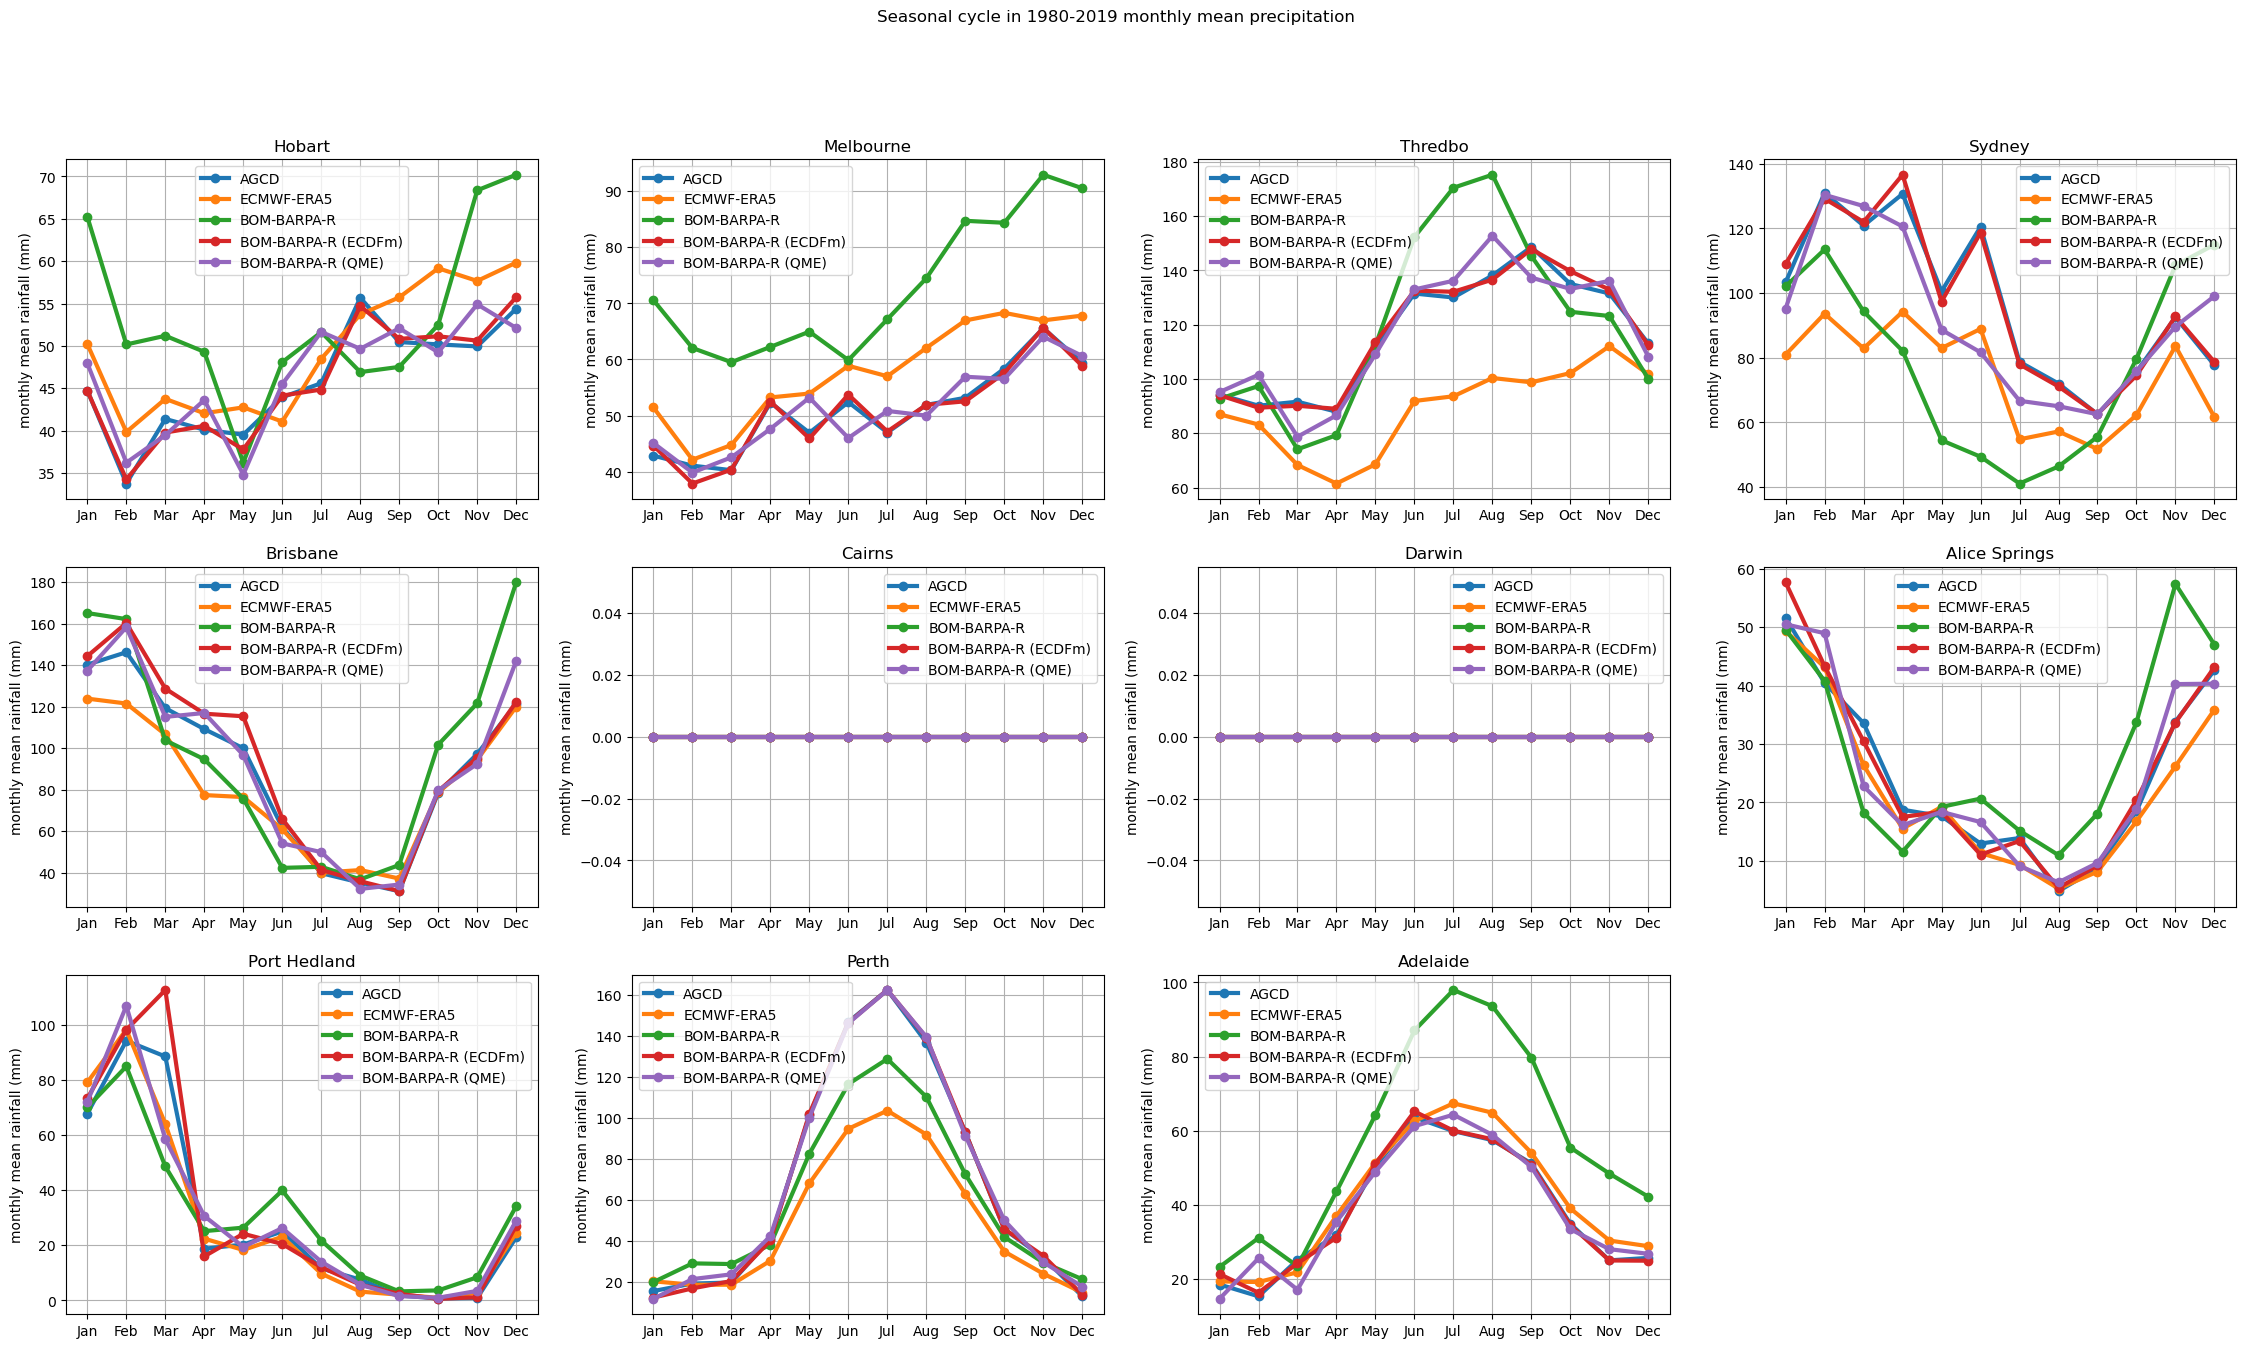

In [20]:
plot_city_cycles(da_dict, gcm, rcm, task)